In [28]:
# autoreload magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import numpy as np
config = {'p': 0.05, 'var': 0.03}
p = config.get('p')
# alpha = config.get('alpha')
var = config.get('var')
np.random.seed(222) # just for reproducibility
p_samp = np.random.normal(p, var, size=n)
print(p_samp)

[0.10890275 0.05827309 0.06375975 0.08003794 0.02708494 0.07165783
 0.02283591 0.0800562  0.03437773]


In [ ]:
from mldec.datasets import toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation

config = {'p': 0.1, 'var': 0.03}
# config = {'p': 0.06, 'var': 0.02}
n = 9
X, Y, weights = toric_code_data.create_dataset_training(n, config, cache=True)

In [ ]:
# X, Y, weights = toric_code_data.uniform_over_good_examples(n, config, cache=True)

In [156]:
minimum_weight_decoder = baselines.MinimumWeightPerfectMatching()
minimum_weight_decoder.make_decoder(X, Y)
preds = minimum_weight_decoder.predict(X).numpy()
# i = 0
# j = 0
# for x, y, pred, wt in zip(X, Y, preds, weights):
#     print(x, y, pred, wt)
#     i += 1
#     if i == 4:
#         print()
#         i = 0
#     j += 1
#     if j > 20:
#         break
minimum_weight_val_acc = evaluation.weighted_accuracy(minimum_weight_decoder, X, Y, weights)
print(f"Minimum weight decoder validation accuracy: {minimum_weight_val_acc}")

Minimum weight decoder validation accuracy: 0.99845290184021


In [106]:
X, Y, weightsb, hist = toric_code_data.sample_virtual_XY(weights, 1000, n, config, cache=True)
print(X.shape, Y.shape, weightsb.shape, hist.shape)

torch.Size([249, 8]) torch.Size([249, 2]) torch.Size([249]) (1024,)


In [ ]:
x_generators, z_generators, Hx, Hz = toric_code.rotated_surface_code_stabilizers(3)
generators = x_generators + z_generators
t = stim.Tableau.from_stabilizers(generators, allow_redundant=True, allow_underconstrained=True)
# we leave out the final stabilizer that canonically represents the degree of 
# freedom for a state we didn't specify
generators_S = [t.z_output(k) for k in range(len(t) - 1)] # stabilizer generators, ordered X type then Z type
generators_T = [t.x_output(k) for k in range(len(t) - 1)] # pure error generators, arbitrary order
generators_L = toric_code.rotated_toric_code_logicals(3) # logicals, ordered X type then Z type


In [ ]:



def build_lst_lookup_and_mle(generators_S, generators_T, generators_L, Hx, Hz, noise_model):
    """Starting from STL, create a lookup table mapping an error to a (syndrome, ell) pair.

    Note: The S,L generators are expected to be [logical_xs, logical_zs] 
    errors in returned hash are binary symplectic form

    Conventions:
     - sigma_z means syndromes for z-stabilizer violations

    TIE-BREAKING: If there are multiple cosets with the same probability, there is no consistent
    way to break ties so that MWPM matches MLE in the iid situation. So, we will return
    the set of all cosets that are tied for the most likely. This means the mle_lookup will
    be ragged, and should be handled carefully.


    Args:
        generators_S: list of generators of the stabilizer group
        generators_T: list of pure errors
        generators_L: list of logical Pauli operators
        Hx, Hz: PCMs for the x- and z-stabilizers
    
    Returns: This is a two-for-one function, returning both the LST lookup table and the MLE lookup table
        lst: a dictionary mapping errors to (syndrome, ell) pairs
            {(error_x, error_z): (np.array([syndrome_x, syndrome_z]), np.array([logical_x, logical_z]))}
                error_x: shape n
                syndrome_x: shape r
                logical_x: shape k
            where syndrome_x is the syndrome for x-stabilizers (in order)
            logical_x is a bitmask for logical operators in logical_x
        mle: a dictionary mapping syndromes to the set of most likely logical _errors_
            {(syndrome_x, syndrome_z): [np.array([logical_x, logical_z]), ...]}
    
    """

    # about 6 seconds

    r = len(generators)
    n = len(generators[0])
    k = n - r
    assert len(generators_L) == 2*k
    assert len(generators_T) == r
    lst = {}
    mle = {}
    err_prs = {}
    mle_acc = 0

    for a, pure_error_lst in enumerate(powerset(generators_T)):
        pure_error = operator_sequence_to_stim(pure_error_lst, n)
        xerr, zerr = pure_error.to_numpy()
        if len(xerr) == 0 and len(zerr) == 0:
            xerr = np.zeros(n, dtype=int)
            zerr = np.zeros(n, dtype=int)
        sigma_z = (Hz @ xerr) % 2
        sigma_x = (Hx @ zerr) % 2
        sigma = np.concatenate((sigma_x, sigma_z), axis=0)
        # we will fill up logical_probs with corresponding total probabilities, then pick the biggest
        # the logical masks are [logical_x, logical_z] bitmasks
        logical_probs = np.zeros(4**k)
        logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
        for b, logical_mask in enumerate(logical_masks):
            # to enumerate over the logicals, we want to preserve their order 
            # as provided in generators_L, as this will determine the binary
            # mask representing that logical
            logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
            logical_op = operator_sequence_to_stim(logical_op_lst, n)
            for c, stabilizer_lst in enumerate(powerset(generators_S)):
                stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
                error = pure_error * logical_op * stabilizer
                error_symplectic = np.concatenate(error.to_numpy(), axis=0).astype(int)
                p_err = noise_model(n, error_symplectic)
                err_key = tuple(error_symplectic)
                err_prs[err_key] = p_err
                lst[err_key] = (sigma, np.array(logical_mask))
                logical_probs[b] += p_err
        # no tiebreak, just return everything that is consistent.
        best = logical_probs.max()
        mle_acc += best
        rtol = 1e-6
        winners = np.nonzero(np.isclose(logical_probs, best, rtol=rtol))[0]
        mle[tuple(sigma)] = logical_masks[winners]


    return lst, mle, mle_acc, err_prs

def make_depol_noise_model(n, config):
    p = config.get('p')
    alpha = config.get('alpha')
    def depol_noise_model(n, err):
        """
        Args:
            error: [error_x, error_z] with length 2n
        """

        wt = sum(np.logical_or(err[:n], err[n:]))
        out = (p/3)**wt * (1-p)**(n-wt)
        return out
    return depol_noise_model


# def biased_noise_model(n, err, config):
#     """
#     Biased noise model where half of the qubits are more likely to depolarize
#     """
#     p = config.get('p')
#     alpha = config.get('alpha')
#     p1 = p
#     p2 = p * alpha
#     err_str = np.logical_or(err[:n], err[n:])
#     p_first = np.prod((p1/3)*err_str[:n//2] +(1-p1)*(1-err_str[:n//2]))
#     p_second = np.prod((p2/3)*err_str[n//2:] + (1-p2)*(1-err_str[n//2:]))
#     return np.multiply(p_first, p_second)



In [81]:

def make_variance_noise_model(n, config):
    p = config.get('p')
    # alpha = config.get('alpha')
    var = config.get('var')
    np.random.seed(222) # just for reproducibility
    p_samp = np.random.normal(p, var, size=n)
    print(p_samp)
    def variance_noise_model(n, err):
        """
        After sampling some vector (p_1, ..., p_n) with variance var, each qubit has a different 
         depol. channel probability p_i

        Args:
            error: [error_x, error_z] with length 2n
        """
        is_err = np.logical_or(err[:n], err[n:]).astype(bool)
        is_not_err = np.logical_not(is_err).astype(bool)
        error_prob = np.prod(p_samp[is_err] / 3)
        no_error_prob = np.prod(1-p_samp[is_not_err])
        out = error_prob * no_error_prob
        return out
    
    return variance_noise_model


In [120]:
L = 3
n = 9
# noise = 'depol'
noise = 'variance'
if noise == 'depol':
    noise_config = {'p': 0.1}
    noise_model = make_depol_noise_model(n, noise_config)
elif noise == 'variance':
    noise_config = {'p': 0.1, 'var': 0.03}
    # noise_config = {'p': 0.2, 'var': 0.05}
    noise_model = make_variance_noise_model(n, noise_config)

    
lst, mle_lookup, mle_acc, err_prs = build_lst_lookup_and_mle(generators_S, generators_T, generators_L, Hx, Hz, noise_model)


[0.15890275 0.10827309 0.11375975 0.13003794 0.07708494 0.12165783
 0.07283591 0.1300562  0.08437773]


In [121]:
def build_mwpm_lookup(L, Hx, Hz, generators_L, lookup):
    """Create a lookup table for the output of MWPM decoding that error.
    
    Args:
        L: the side length of the lattice
        Hx, Hz: the parity check matrices for the x- and z-stabilizers
        generators_L: the logical operators
        lookup: A lookup mapping errors to (syndrome, logical) pairs. Since we're computing 
            this anyways, we can save time on Gaussian elim to find a logical op coset containing
            to each mwpm error prediction
    Returns
        dct: a dictionary mapping
            {(syndrome_x, syndrome_z): np.array([logical_x, logical_z])}

    """
    x_logical, z_logical = generators_L
    x_logical = x_logical.to_numpy()[0]
    z_logical = z_logical.to_numpy()[1]
    if L != 3:
        raise NotImplementedError("Only L=3 is supported for now")
    
    n = L ** 2
    # generate a matching object specific to the PCM for x-stabilizers
    matching_x = Matching(Hx)
    matching_z = Matching(Hz)
    out = {}
    for i, sigma_x in enumerate(itertools.product([0, 1], repeat=4)): # syndrome for z-type errors i.e. x-stabilizer violations
        zerr_pred = matching_x.decode(np.array(sigma_x))
        for j, sigma_z in enumerate(itertools.product([0, 1], repeat=4)): # x-type errors, i.e. z-stabilizer violations

            xerr_pred = matching_z.decode(np.array(sigma_z))
            # MWPM has predicted the error, now we determine which logical coset this belongs to.
            err_pred = np.concatenate((xerr_pred, zerr_pred), axis=0)
            _, logical_op = lookup[tuple(err_pred)]
            out[tuple(sigma_x + sigma_z)] = logical_op
    return out

mwpm_lookup = build_mwpm_lookup(L, Hx, Hz, generators_L, lst)

In [122]:
# compute the syndrome probabilities and syndrome weight distributions

def build_syndrome_probs_and_weight_distr(generators_S, generators_T, generators_L, Hx, Hz, noise_model):
    """Compute a table of syndrome probabilities, and a table of error weight distribution by syndrome.

    Returns:
        p_SL: a dictionary mapping (sigma, ell) to the probability of that pair
        hist_SL_wts: a dictionary mapping (sigma, ell) an (n+1) array of weights, where the ith entry is the 
            cum. probability of errors in that coset enumerator having weight i
    """

    p_SL = {}
    hist_SL_wts = {}

    r = len(generators)
    n = len(generators[0])
    k = n - r
    assert len(generators_L) == 2*k
    assert len(generators_T) == r
    for a, pure_error_lst in enumerate(powerset(generators_T)):
        pure_error = operator_sequence_to_stim(pure_error_lst, n)
        xerr, zerr = pure_error.to_numpy()
        sigma_z = (Hz @ xerr) % 2
        sigma_x = (Hx @ zerr) % 2
        sigma = np.concatenate((sigma_x, sigma_z), axis=0)
        p_sigma = 0
        logical_masks = np.array(list(itertools.product([0, 1], repeat=2*k)))
        for b, logical_mask in enumerate(logical_masks):
            # to enumerate over the logicals, we want to preserve their order 
            # as provided in generators_L, as this will determine the binary
            # mask representing that logical
            p_SL[(tuple(sigma), tuple(logical_mask))] = 0
            hist_SL_wts[(tuple(sigma), tuple(logical_mask))] = np.zeros(n+1)
            logical_op_lst = [generators_L[i] for i, bit in enumerate(logical_mask) if bit]
            logical_op = operator_sequence_to_stim(logical_op_lst, n)
            for c, stabilizer_lst in enumerate(powerset(generators_S)):
                stabilizer = operator_sequence_to_stim(stabilizer_lst, n)
                error = pure_error * logical_op * stabilizer
                error_symplectic = np.concatenate(error.to_numpy(), axis=0).astype(int)
                p_err = noise_model(n, error_symplectic)
                wt = sum(np.logical_or(error_symplectic[:n], error_symplectic[n:]))

                # increment the probability of this (sigma, ell) pair, and the weight enumerator for this
                p_SL[(tuple(sigma), tuple(logical_mask))] += p_err
                hist_SL_wts[(tuple(sigma), tuple(logical_mask))][wt] += p_err
            

    return p_SL, hist_SL_wts

In [123]:
p_SL, hist_SL_wts = build_syndrome_probs_and_weight_distr(generators_S, generators_T, generators_L, Hx, Hz, noise_model)

### V&V

A few sanity checks for v/v:
 - We know MWPM should be MLD for iid noise with _uncorrelated_ X- and Z- errors (not the same as "independent" in iid!). So I verified that there are no important errors for a bitflip-only model, i.e. MWPM is MLD in that case.
 

In [124]:

n = L**2
weights = np.arange(0, n+1)
unimportant_prs = np.zeros(n+1)
bad_prs = np.zeros(n+1)
important_prs = np.zeros(n+1)

for syndrome in itertools.product([0, 1], repeat=n-1):
    syndrome = tuple(syndrome)
    logical_mles = mle_lookup[syndrome]
    logical_mwpm = mwpm_lookup[syndrome]
    syndrome_not_counted = True

    for logical in itertools.product([0,1], repeat=2):
        logical = tuple(logical)
        f0_is_correct = not sum(logical_mwpm ^ logical) 
        fstar_is_correct = any(np.equal(logical_mles, logical).all(1)) 
        f0_in_fstar = any(np.equal(logical_mles, logical_mwpm).all(1))
        p_sigma_logical = p_SL[(syndrome, logical)]

        # for each of the errors in the enumerator, we update
        # the corresponding distribution (important, unimportant, bad)
        # with the probability of this error, at the error's weight
        wt_distr = hist_SL_wts[(syndrome, logical)]
    
        if fstar_is_correct and syndrome_not_counted:
            # we only count one syndrome as the answer to MLE
            syndrome_not_counted = False
            # TODO: need a scheme for weight enumeration here.
            if not f0_is_correct:
                important_prs += wt_distr
            else:
                unimportant_prs += wt_distr
        else:
            bad_prs += wt_distr

print(unimportant_prs)
print(important_prs)
print(bad_prs)
# compute the sum of all 3
print(sum(unimportant_prs) + sum(important_prs) + sum(bad_prs))

[3.46193958e-01 3.91345557e-01 9.49827172e-02 1.07273453e-02
 1.42477095e-03 1.57376338e-04 1.17831931e-05 7.00961000e-07
 2.23211213e-08 2.14687689e-10]
[0.00000000e+00 0.00000000e+00 3.35400439e-02 6.21470220e-03
 1.16422680e-03 1.37193600e-04 1.13160530e-05 6.14238110e-07
 1.73191042e-08 1.82605691e-10]
[0.00000000e+00 0.00000000e+00 6.62852431e-02 3.90988545e-02
 7.67668303e-03 9.47013843e-04 7.60283982e-05 3.72187823e-06
 1.08158090e-07 1.51047085e-09]
1.0


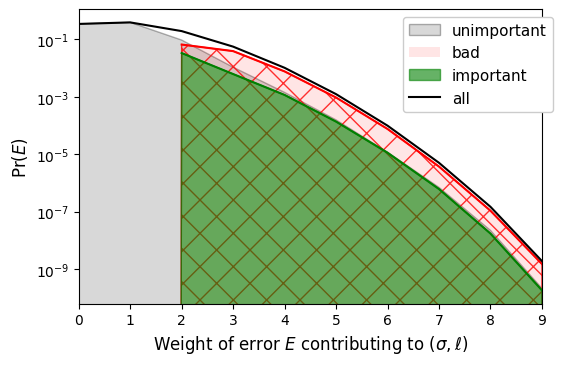

In [136]:
import matplotlib.pyplot as plt
cm = 1/2.54
fig, ax = plt.subplots(1, 1, figsize=(14*cm, 9*cm), constrained_layout = True)
#matplotlib rendering bug https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf

zero = min(bad_prs)

ax.fill_between(weights, important_prs, unimportant_prs, label='unimportant', facecolor="grey", edgecolor='k', alpha=0.3)
# ax.plot(weights, unimportant_prs, label='unimportant', c='k', alpha=1)
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, label='bad', facecolor="r",  alpha=0.1)
ax.plot(weights[bad_prs>0], bad_prs[bad_prs>0], alpha=1, c='r') # bold line
ax.fill_between(weights, np.ones_like(bad_prs) * zero, bad_prs, facecolor='none', hatch="x", edgecolor='r', alpha=.8)  #hatching nonalpha

ax.fill_between(weights, np.ones_like(important_prs) * zero, important_prs, label='important', facecolor='g', edgecolor='g', alpha=0.6, )
ax.plot(weights[important_prs>0], important_prs[important_prs>0], c='g', alpha=1 )
# ax.fill_between(weights, np.ones_like(important_prs) * zero, important_prs, label='important',  facecolor="none",  hatch='|', edgecolor='g', alpha=.8, )
all = unimportant_prs + important_prs + bad_prs
ax.plot(weights, all, label='all', c='k', alpha=1)

ax.set_xlim(0, n)
labelsz = 12
ax.set_xlabel(r"Weight of error $E$ contributing to $(\sigma, \ell)$", fontsize=labelsz)
ax.set_ylabel(r"$\text{Pr}(E)$", fontsize=labelsz)
ax.semilogy()
ax.legend(prop={'size': 11}, framealpha=1, loc='upper right', bbox_to_anchor=(1.04, 1))


fig.savefig('../../figures/toric_code_histogram.pdf', bbox_inches='tight')
print()

In [245]:
print(unimportant_prs)
print(important_prs)
print(bad_prs)

[7.17657949e-01 2.43093313e-01 1.76467564e-02 6.01221729e-04
 2.33991090e-05 7.51503890e-07 1.60727735e-08 2.75013586e-10
 2.51263719e-12 6.93672939e-15]
[0.00000000e+00 0.00000000e+00 5.90335804e-03 3.27378148e-04
 1.85833974e-05 6.37604652e-07 1.51318462e-08 2.37834664e-10
 1.91931891e-12 5.76148556e-15]
[0.00000000e+00 0.00000000e+00 1.24660333e-02 2.13344531e-03
 1.22622930e-04 4.41379954e-06 1.03009003e-07 1.45223964e-09
 1.21085712e-11 4.83369413e-14]
